# Task 2: Model Training with LightGBM and Evaluation

### Handling Class Imbalance

In [3]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Load the data
df = pd.read_csv("../data/final_fraud_data_Processed.csv")  

# Preview class distribution
print("Class distribution before resampling:")
print(df['class'].value_counts())


Class distribution before resampling:
class
0    136961
1     14151
Name: count, dtype: int64


## Train-Test Split

In [6]:
X = df.drop(['class', 'user_id', 'device_id', 'ip_address', 'signup_time', 'purchase_time'], axis=1)
y = df['class']

# Encode categoricals
X = df.drop(['class', 'user_id', 'device_id', 'ip_address', 'signup_time', 'purchase_time'], axis=1).copy()
categorical_cols = ['source', 'browser', 'sex', 'country']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


# Scale numerics
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("Training target distribution:", Counter(y_train))

Training target distribution: Counter({0: 95872, 1: 9906})


## Apply SMOTE to Handle Imbalance

In [7]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled training target distribution:", Counter(y_train_resampled))


Resampled training target distribution: Counter({0: 95872, 1: 95872})


In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, roc_auc_score, 
    average_precision_score, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns


## Logistic Regression (Baseline Model)

Classification Report (LogReg):
               precision    recall  f1-score   support

           0       0.95      0.65      0.77     41089
           1       0.17      0.69      0.27      4245

    accuracy                           0.65     45334
   macro avg       0.56      0.67      0.52     45334
weighted avg       0.88      0.65      0.73     45334

F1 Score: 0.272777932571747
ROC-AUC Score: 0.7517652063902998
AUC-PR Score: 0.4042839346514586


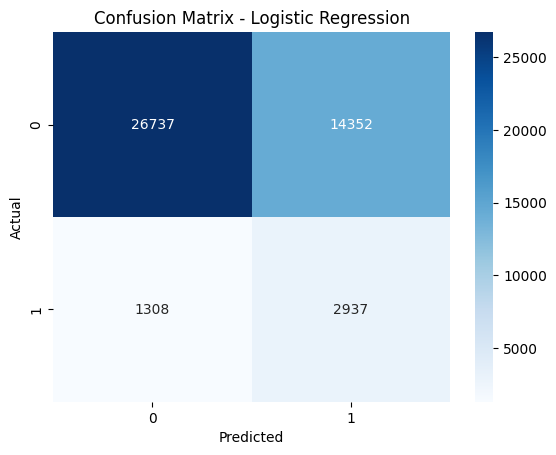

In [10]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)
y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]

print("Classification Report (LogReg):\n", classification_report(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))
print("AUC-PR Score:", average_precision_score(y_test, y_proba_lr))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## LightGBM Classifier

[LightGBM] [Info] Number of positive: 95872, number of negative: 95872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3745
[LightGBM] [Info] Number of data points in the train set: 191744, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\sami1\Documents\tenx\fraud-detection-for-e-commerce\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sami1\Documents\tenx\fraud-detection-for-e-commerce\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report (LightGBM):
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.53      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334

F1 Score: 0.6954517516902274
ROC-AUC Score: 0.7679600697855995
AUC-PR Score: 0.6244217126020435


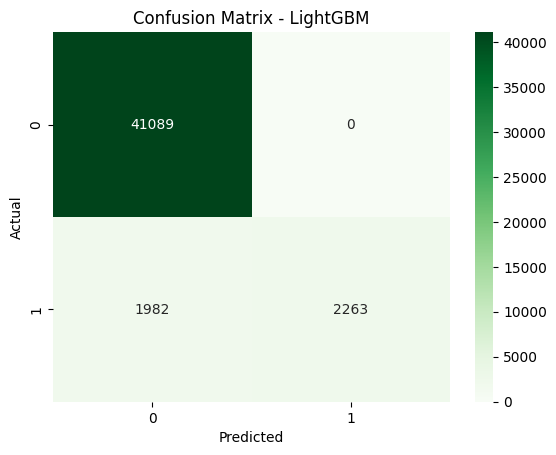

In [11]:
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_estimators=100)
lgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

print("Classification Report (LightGBM):\n", classification_report(y_test, y_pred_lgb))
print("F1 Score:", f1_score(y_test, y_pred_lgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lgb))
print("AUC-PR Score:", average_precision_score(y_test, y_proba_lgb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Model Evaluation Summary

I evaluated two models, Logistic Regression and LightGBM, using metrics appropriate for imbalanced classification, such as **F1 Score**, **ROC-AUC**, **AUC-PR**, and the **Confusion Matrix**.

---

### Logistic Regression (Baseline Model)

- **Precision (fraud class)**: 0.17  
- **Recall (fraud class)**: 0.69  
- **F1 Score (fraud class)**: 0.27  
- **ROC-AUC**: 0.75  
- **AUC-PR**: 0.40  
- **Confusion Matrix**:
  - Misses many non-fraud cases (high false positives)
  - Decent recall on fraud detection, but very low precision

-> Logistic Regression captures many fraud cases (good recall) but wrongly flags a large number of non-fraud cases as fraud (poor precision). This may not be ideal in real-world use due to high false alarm rates.

---

### LightGBM (Ensemble Model)

- **Precision (fraud class)**: 1.00  
- **Recall (fraud class)**: 0.53  
- **F1 Score (fraud class)**: 0.70  
- **ROC-AUC**: 0.77  
- **AUC-PR**: 0.62  
- **Confusion Matrix**:
  - Accurately identifies almost all non-fraud cases
  - Captures more than half of fraud cases with excellent precision

-> LightGBM performs significantly better overall, especially in achieving a **strong balance between recall and precision**. The higher F1 and AUC-PR scores confirm it’s better suited for the fraud detection problem.

---

### Conclusion

While Logistic Regression provides a useful baseline, **LightGBM is the superior model** for this imbalanced fraud detection task. It offers better predictive power, fewer false positives, and a better trade-off between catching fraud and avoiding unnecessary flags.

